# Explainable AI 

This notebook uses XAI techniques and compares the different methods for base model from RQ1.

## Models

#### Imports & Variables

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader, random_split
from collections import Counter

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
import shutil

import copy

from pathlib import Path
from datetime import datetime

import seaborn as sns
import captum
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution, NoiseTunnel, GuidedGradCam, Saliency
from captum.attr import visualization as viz

from matplotlib.colors import LinearSegmentedColormap

In [2]:
IMAGE_SIZE = [200,200]
BASE_DIR = './UTKFace/'
NR_EPOCHS = 80
BATCH_SIZE = 30
NUM_CLASSES = 116 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### Initialize and load models

#### Age Class Model

In [3]:
class CNNNet(nn.Module):
    def __init__(self, num_classes=116):
        super(CNNNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=7, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(96),

            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(256),

            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(384),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.classifier = nn.Sequential(
            nn.Linear(384, 512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [4]:
model_normal = CNNNet(NUM_CLASSES).to(device)
model_normal.load_state_dict(torch.load('./Project/classes/normal/normal_model'))

<All keys matched successfully>

## Methods 

### Saliency Maps

In [5]:
def captum_saliency (model, image_path, class_label):
    
    transform = transforms.Compose([
     transforms.Resize((200,200)),
     transforms.ToTensor(),
    ])

    #normalization
    transform_normalize = transforms.Normalize(
         mean=[0.485, 0.456, 0.406],
         std=[0.229, 0.224, 0.225]
     )
    
    test_img = Image.open(image_path).convert('RGB')
    transformed_img = transform(test_img)
    input_img = transform_normalize(transformed_img)
    input_img = input_img.unsqueeze(0)
    input_img = input_img.to(device)
   
    model.eval()
    output = model(input_img)
    model.zero_grad()

    predict = nn.Softmax(dim=1)(output).argmax(dim=1).item() + 1

    print(f'Predicted Age: {predict}  Real Age: {class_label}')
    
    target = torch.zeros(output.shape, dtype=torch.float)
    
    # choose target based on prediction
    target[0][predict - 1] = 1
    
    saliency = Saliency(model)
    noise_tunnel = NoiseTunnel(saliency)

    attributions_saliency = saliency.attribute(input_img, target=predict)

    _ = viz.visualize_image_attr_multiple(np.transpose(attributions_saliency.squeeze().cpu().detach().numpy(), (1,2,0)),
                                          np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                          ["original_image", "heat_map"],
                                          ["all", "positive"],
                                          cmap='jet',
                                          show_colorbar=True,
                                          titles=['Original Image', 'Vanilla Saliency'],
                                          use_pyplot=True,
                                          )


Predicted Age: 58  Real Age: 50


/home/flynx/Master/venv/lib/python3.12/site-packages/captum/attr/_core/saliency.py:129: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)


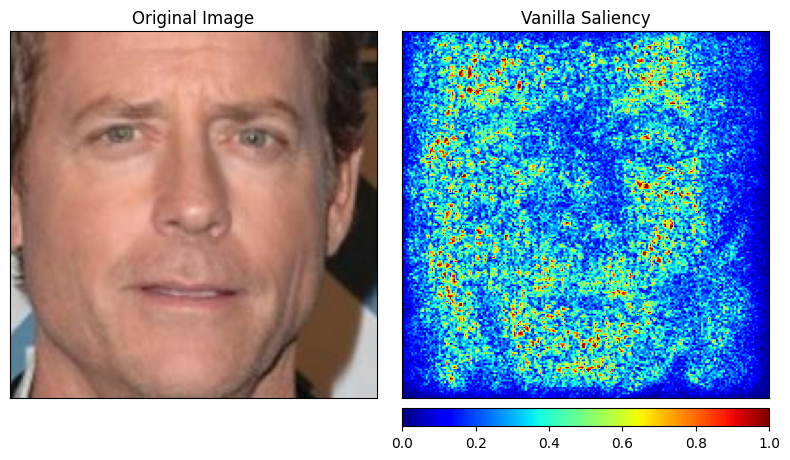

In [6]:
captum_saliency(model_normal, './Test_imgs/Test_IMG_50.jpg', 50)

In [13]:
def integrated_gradients(model, image_path, class_label):
    
    transform = transforms.Compose([
     transforms.Resize((200,200)),
     transforms.ToTensor(),
    ])

    #normalization
    transform_normalize = transforms.Normalize(
         mean=[0.485, 0.456, 0.406],
         std=[0.229, 0.224, 0.225]
     )
    
    test_img = Image.open(image_path).convert('RGB')
    transformed_img = transform(test_img)
    input_img = transform_normalize(transformed_img)
    input_img = input_img.unsqueeze(0)
    input_img = input_img.to(device)
   
    model.eval()
    output = model(input_img)
    model.zero_grad()

    predict = nn.Softmax(dim=1)(output).argmax(dim=1).item() + 1

    print(f'Predicted Age: {predict}  Real Age: {class_label}')
    
    target = torch.zeros(output.shape, dtype=torch.float)
    
    # choose target based on prediction
    target[0][predict - 1] = 1
    
    integrated_gradients = IntegratedGradients(model)
    noise_tunnel = NoiseTunnel(integrated_gradients)

    attributions_ig_nt = noise_tunnel.attribute(input_img, nt_samples=50, nt_samples_batch_size=2, stdevs=0.04, nt_type='smoothgrad', target=predict)
    
    _ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                          np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                          ["original_image", "heat_map"],
                                          ["all", "positive"],
                                          cmap='jet',
                                          show_colorbar=True,
                                          titles=['Original Image', 'Integrated Gradients'],
                                          use_pyplot=True,
                                          )


#### Normal Model

Predicted Age: 58  Real Age: 50


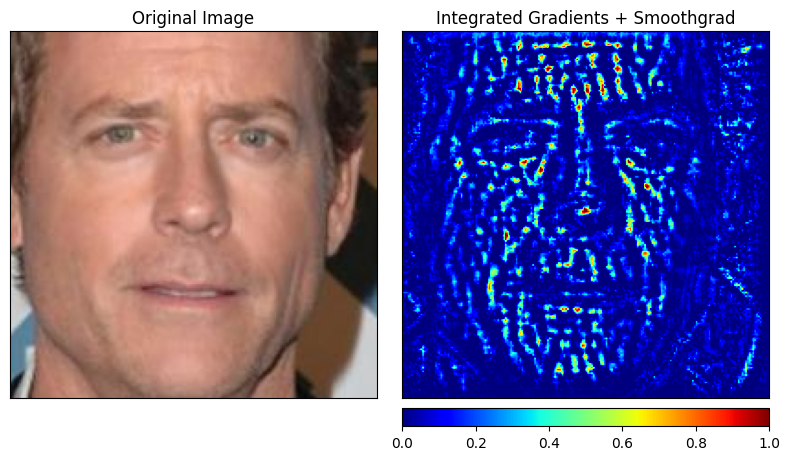

In [14]:
integrated_gradients(model_normal, './Test_imgs/Test_IMG_50.jpg', 50)

### Occlusion

In [9]:
## https://captum.ai/tutorials/TorchVision_Interpret
def occlusion(model, image_path, class_label):
    
    transform = transforms.Compose([
     transforms.Resize((200,200)),
     transforms.ToTensor()
    ])
    
    #normalization
    transform_normalize = transforms.Normalize(
         mean=[0.485, 0.456, 0.406],
         std=[0.229, 0.224, 0.225]
     )
    

    test_img = Image.open(image_path).convert('RGB')
    
    transformed_img = transform(test_img)
    input_img = transform_normalize(transformed_img)
    input_img = input_img.unsqueeze(0)
    input_img = input_img.to(device)
   
    
    model.eval()
    output = model(input_img)
    model.zero_grad()

    predict = nn.Softmax(dim=1)(output).argmax(dim=1).item() + 1
    
    print(f'Predicted Age: {predict}  Real Age: {class_label}')

    target = torch.zeros(output.shape, dtype=torch.float)
    # choose target based on prediction
    target[0][predict - 1] = 1
    
    occlusion = Occlusion(model)

    attributions_occ = occlusion.attribute(input_img,
                                       target=predict,
                                       strides=(3, 8, 8),
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)
    
    _ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                          np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                          ["original_image", "heat_map", "heat_map", "masked_image"],
                                          ["all", "positive", "negative", "positive"],
                                          show_colorbar=True,
                                          titles=["Original", "Positive Attribution", "Negative Attribution", "Masked"],
                                          fig_size=(18, 6),
                                          #use_pyplot=True,
                                          )



#### Normal Model

Predicted Age: 58  Real Age: 50


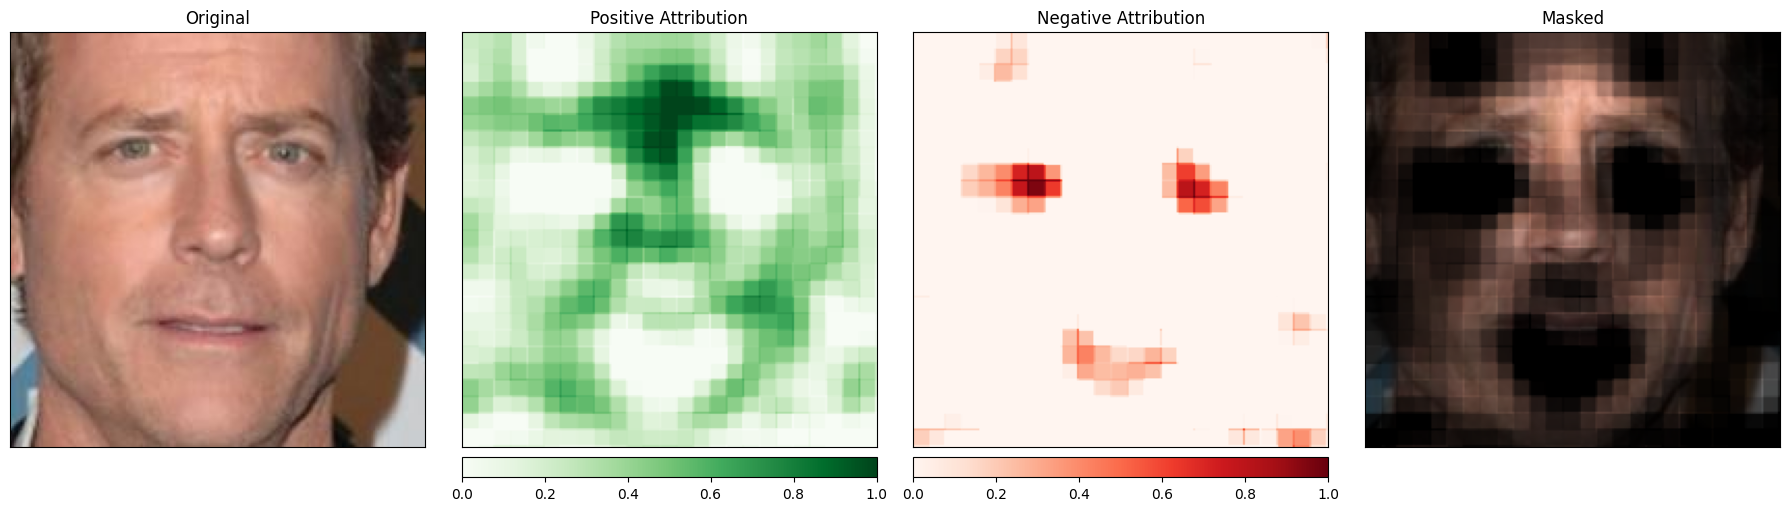

In [10]:
occlusion(model_normal, './Test_imgs/Test_IMG_50.jpg', 50)

### Layer-Grad-CAM & Guided-Grad-CAM

In [11]:
def GradCAM(model, image_path, class_label, layer):
    
    transform = transforms.Compose([
     transforms.Resize((200,200)),
     transforms.ToTensor()
    ])
    
    #normalization
    transform_normalize = transforms.Normalize(
         mean=[0.485, 0.456, 0.406],
         std=[0.229, 0.224, 0.225]
     )
    

    test_img = Image.open(image_path).convert('RGB')
    
    transformed_img = transform(test_img)
    input_img = transform_normalize(transformed_img)
    input_img = input_img.unsqueeze(0)
    input_img = input_img.to(device)
    input_img.requires_grad_()
   
    
    model.eval()
    output = model(input_img)
    model.zero_grad()

    predict = nn.Softmax(dim=1)(output).argmax(dim=1).item() + 1
    print(f'Predicted Age: {predict}  Real Age: {class_label}')
    
    target = torch.zeros(output.shape, dtype=torch.float)
    # choose target based on prediction
    target[0][predict - 1] = 1
    
    # layer_gradcam
    layer_gradcam = LayerGradCam(model, layer)
   
    attributions_lgc = layer_gradcam.attribute(input_img, target=predict)
    
    _ = viz.visualize_image_attr(attributions_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                             fig_size=(18, 6),
                             sign="all",
                             show_colorbar=True,
                             title="Layer-GradCAM Last Convolution Layer")

    # guided_grad_cam
    guided_gc = GuidedGradCam(model, layer)
    
    attributtions_ggc = guided_gc.attribute(input_img, target=predict)
    
    _ = viz.visualize_image_attr(np.transpose(attributtions_ggc[0].squeeze().cpu().detach().numpy(), (1,2,0)),
                                 fig_size=(18, 6),
                                 sign="positive",
                                 show_colorbar=True,
                                 title="Guided-GradCAM Last Convolution Layer")
    

    

Predicted Age: 58  Real Age: 50


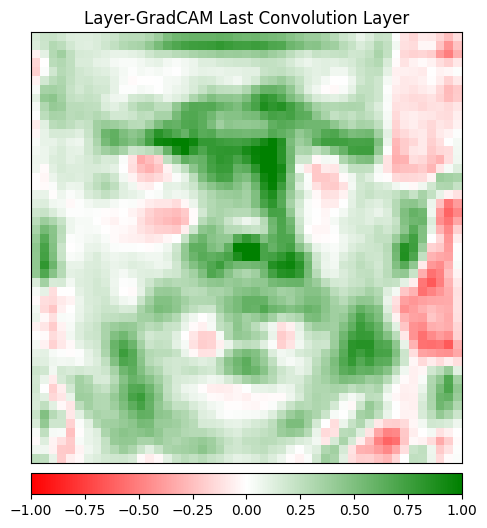

/home/flynx/Master/venv/lib/python3.12/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:66: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(
/home/flynx/Master/venv/lib/python3.12/site-packages/captum/attr/_utils/visualization.py:110: UserWarning: Attempting to normalize by value approximately 0, visualized resultsmay be misleading. This likely means that attribution values are allclose to 0.
  return _normalize_scale(attr_combined, threshold)


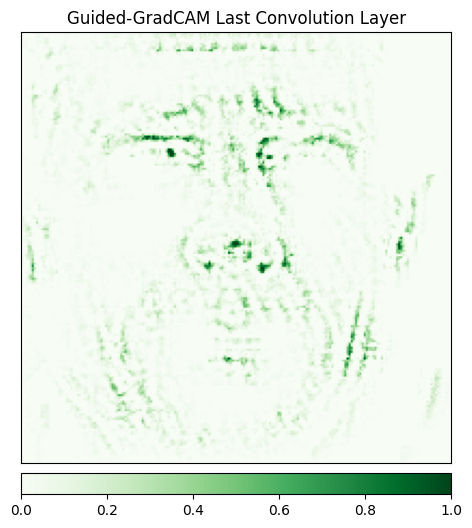

In [12]:
GradCAM(model_normal, './Test_imgs/Test_IMG_50.jpg', 50, model_normal.features[8])